In [29]:
#Imports
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data as mnist_data
import math
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

#Load Data
# Download images and labels into mnist.test (10K images+labels) and mnist.train (60K images+labels)
mnist = mnist_data.read_data_sets("data", one_hot=True, reshape=False, validation_size=0)

#Define model
batchSize = None;       # put None for right now as we dont know yet
imgHeight = 28
imgWidth = 28
numOfColors = 1         # gray scale images

numberOfClasses = 10    # 10 classes: 0-9

# Size of each layer:
sizeLayerZero = 12
sizeLayerOne = 24
sizeLayerTwo = 48
sizeLayerThree = 64
sizeLayerFour = 200
sizeLayerFive = numberOfClasses       # the final layer is the output layer

stridesL1 = [1,1,1,1]
stridesL2 = [1,2,2,1]
stridesL3 = [1,2,2,1]

#Inputs si placeholders:
X_img = tf.placeholder(tf.float32, [batchSize, imgHeight, imgWidth, numOfColors], name="X_img")
Y_True = tf.placeholder(tf.float32, [batchSize, 10])
learningRate = tf.placeholder(tf.float32)
probKeep = tf.placeholder(tf.float32, name="Prob_Keep")

#Variabila globala pentru probabilitatea de dropout
PROBKEEP = 0.6

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [0]:
#Definirea straturilor
with tf.name_scope("Layer_0_Conv"):
    W0 = tf.Variable(tf.truncated_normal([4,4,1,sizeLayerZero], stddev=0.1), name="Weights")    
    b0 = tf.Variable(tf.ones([sizeLayerZero])/10, name="Bias")    
    Y0 = tf.nn.relu(tf.nn.conv2d(X_img, W0, strides=stridesL1, padding='SAME') + b0)
    
with tf.name_scope("Layer_1_Conv"):
    W1 = tf.Variable(tf.truncated_normal([6,6,sizeLayerZero,sizeLayerOne], stddev=0.1), name="Weights")    
    b1 = tf.Variable(tf.ones([sizeLayerOne])/10, name="Bias")    
    Y1 = tf.nn.relu(tf.nn.conv2d(Y0, W1, strides=stridesL1, padding='SAME') + b1)
    
with tf.name_scope("Layer_2_Conv"):
    W2 = tf.Variable(tf.truncated_normal([5,5,sizeLayerOne,sizeLayerTwo], stddev=0.1), name="Weights")
    b2 = tf.Variable(tf.ones([sizeLayerTwo])/10, name="Bias")    
    Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=stridesL2, padding='SAME') + b2)
    
  #  pool1 = tf.layers.max_pooling2d(inputs=Y2, pool_size=[2, 2], strides=2)
    
with tf.name_scope("Layer_3_Conv"):
    W3 = tf.Variable(tf.truncated_normal([4,4,sizeLayerTwo,sizeLayerThree], stddev=0.1), name="Weights")    
    b3 = tf.Variable(tf.ones([sizeLayerThree])/10, name="Bias")    
    Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=stridesL3, padding='SAME') + b3)

with tf.name_scope("Layer_4_FC"):
    W4 = tf.Variable(tf.truncated_normal([7*7*sizeLayerThree,sizeLayerFour], stddev=0.1), name="Weights")    
    b4 = tf.Variable(tf.ones([sizeLayerFour])/10, name="Bias")    
    
    # flatten the last layers output
    Y3_Flat = tf.reshape(Y3, shape=[-1, 7 * 7 * sizeLayerThree], name="flatten")    
    Y4 = tf.nn.relu(tf.matmul(Y3_Flat, W4) + b4)
   
    # Dropout
    Y4_Dropout = tf.nn.dropout(Y4, probKeep)
    
with tf.name_scope("Output_Layer"):
    W5 = tf.Variable(tf.truncated_normal([sizeLayerFour, sizeLayerFive], stddev=0.1), name="Weights")    
    b5 = tf.Variable(tf.ones([sizeLayerFive])/10, name="Bias")   
    Y_logits = tf.matmul(Y4_Dropout, W5) + b5    
    Y_Pred = tf.nn.softmax(Y_logits, name="Activation")

In [31]:
#Training

# normalized cross entropy loss
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Y_logits, labels=Y_True)
cross_entropy = tf.reduce_mean(cross_entropy)*100

# accuracy of the trained model, between 0 (worst) and 1 (best)
correct_prediction = tf.equal(tf.argmax(Y_Pred, 1), tf.argmax(Y_True, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# training step
trainStep = tf.train.AdamOptimizer(learningRate).minimize(cross_entropy)

# training parameters
numberOfBatches = 10000
batchSize = 200

trainingAccuracyList = []
trainingLossList = []
testAccuracyList = []
testLossList = []

# learning rate decay
maxLearningRate = 0.003
minLearningRate = 0.0001
decaySpeed = 2000.0  

init = tf.global_variables_initializer()
with tf.Session() as sess:
    
    # actually initialize our variables
    sess.run(init)
    
    # batch-minimization loop
    for i in range(numberOfBatches):
        # get this batches data
        batch_X, batch_Y = mnist.train.next_batch(batchSize)
        
        # calculate new learning rate for this batch:
        learning_Rate = minLearningRate + (maxLearningRate - minLearningRate) * math.exp(-i/decaySpeed)
    
        # setup this batches input dictionary
        #     - including the new learning rate
        #     - and the dropout/probKeep value
        train_data = {X_img: batch_X, Y_True: batch_Y, learningRate: learning_Rate, probKeep: PROBKEEP}
        
        # run the training step on this batch
        sess.run(trainStep, feed_dict=train_data)
        
        # check our accuracy on training and test data 
        # while resetting dropout! 
        if i%100 == 0:
            # compute our success on the training data
            train_data_to_test_on = {X_img: batch_X, Y_True: batch_Y, learningRate: learning_Rate, probKeep: 1.0}
            trainAcc, trainLoss = sess.run([accuracy, cross_entropy], feed_dict=train_data_to_test_on)
    
            # compute our success on the test data
            test_data = {X_img: mnist.test.images, Y_True: mnist.test.labels, probKeep: 1.0}
            testAcc,testLoss = sess.run([accuracy, cross_entropy], feed_dict=test_data)
        #    print("Train " + str(i) + ": accuracy:" + str(trainAcc) + " loss: " + str(trainLoss))
        #    print("Test " + str(i) + ": accuracy:" + str(testAcc) + " loss: " + str(testLoss))
            
            trainingAccuracyList.append(trainAcc)
            trainingLossList.append(trainLoss)
            testAccuracyList.append(testAcc)
            testLossList.append(testLoss)
            
        #    print("Batch number: ",i, "lr: ", learning_Rate, "Test Loss: ", testLoss)
        if i%1000 == 0:
            
            print("Train " + str(i) + ": accuracy:" + str(trainAcc) + " loss: " + str(trainLoss))
            print("Test " + str(i) + ": accuracy:" + str(testAcc) + " loss: " + str(testLoss))           
            print("Batch number: ",i, "lr: ", learning_Rate, "Test Loss: ", testLoss)



Train 0: accuracy:0.115 loss: 607.3938
Test 0: accuracy:0.1031 loss: 623.9146
Batch number:  0 lr:  0.003 Test Loss:  623.9146
Train 1000: accuracy:0.995 loss: 1.8705847
Test 1000: accuracy:0.9901 loss: 2.7006178
Batch number:  1000 lr:  0.0018589389131666372 Test Loss:  2.7006178
Train 2000: accuracy:1.0 loss: 0.44015148
Test 2000: accuracy:0.9918 loss: 2.7047517
Batch number:  2000 lr:  0.0011668503793971828 Test Loss:  2.7047517
Train 3000: accuracy:0.995 loss: 1.6213434
Test 3000: accuracy:0.9915 loss: 2.784476
Batch number:  3000 lr:  0.0007470774644304465 Test Loss:  2.784476
Train 4000: accuracy:1.0 loss: 0.0011041049
Test 4000: accuracy:0.9935 loss: 2.813662
Batch number:  4000 lr:  0.0004924723213861769 Test Loss:  2.813662
Train 5000: accuracy:1.0 loss: 0.033975355
Test 5000: accuracy:0.9937 loss: 2.9378784
Batch number:  5000 lr:  0.00033804649600930654 Test Loss:  2.9378784
Train 6000: accuracy:1.0 loss: 0.020873556
Test 6000: accuracy:0.9931 loss: 3.1372757
Batch number:  

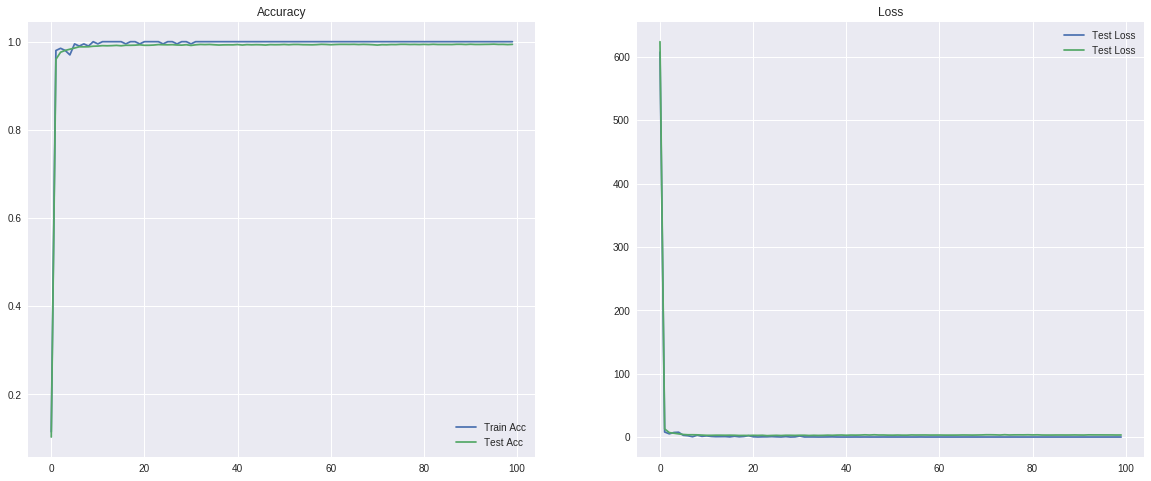

In [32]:
plt.figure(figsize=(20,8))

# Plot Accuracy
plt.subplot(1,2,1);
plt.plot(trainingAccuracyList, label="Train Acc");
plt.plot(testAccuracyList, label="Test Acc");
plt.title("Accuracy");
plt.legend();

# Plot Loss
plt.subplot(1,2,2);
plt.plot(trainingLossList, label="Test Loss");
plt.plot(testLossList, label="Test Loss");
plt.title("Loss");
plt.legend();

In [0]:
from google.colab import files

resultsDic = {"trainAcc": trainingAccuracyList, "trainLoss": trainingLossList, "testAcc": testAccuracyList, "testLoss": testLossList}

with open("mnist-3.1-pkeep-6-results2.txt", "wb") as fp:   #Pickling
    pickle.dump(resultsDic, fp)
    
files.download("mnist-3.1-pkeep-6-results2.txt")


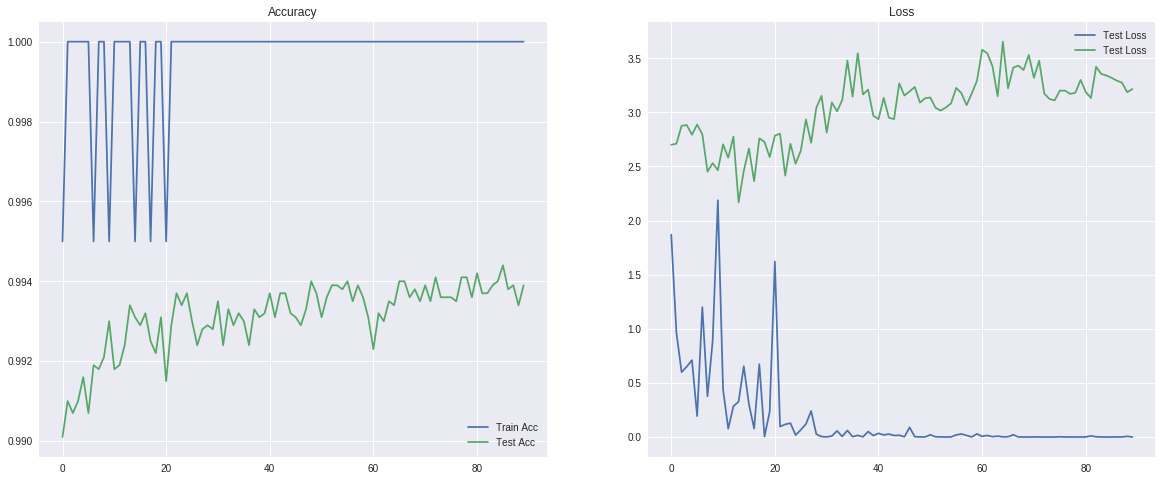

In [34]:
tailLength = -90

plt.figure(figsize=(20,8))

# Plot Accuracy
plt.subplot(1,2,1);
plt.plot(trainingAccuracyList[tailLength:], label="Train Acc");
plt.plot(testAccuracyList[tailLength:], label="Test Acc");
plt.title("Accuracy");
plt.legend();

# Plot Loss
plt.subplot(1,2,2);
plt.plot(trainingLossList[tailLength:], label="Test Loss");
plt.plot(testLossList[tailLength:], label="Test Loss");
plt.title("Loss");
plt.legend();

In [20]:
## upload the mnist-2.2-results.txt file 

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
    with open(fn, "rb") as fp:   #Pickling
        prev_resultsDic = pickle.load(fp)


Saving mnist-3.1-pkeep-6-results.txt to mnist-3.1-pkeep-6-results.txt
User uploaded file "mnist-3.1-pkeep-6-results.txt" with length 10260 bytes


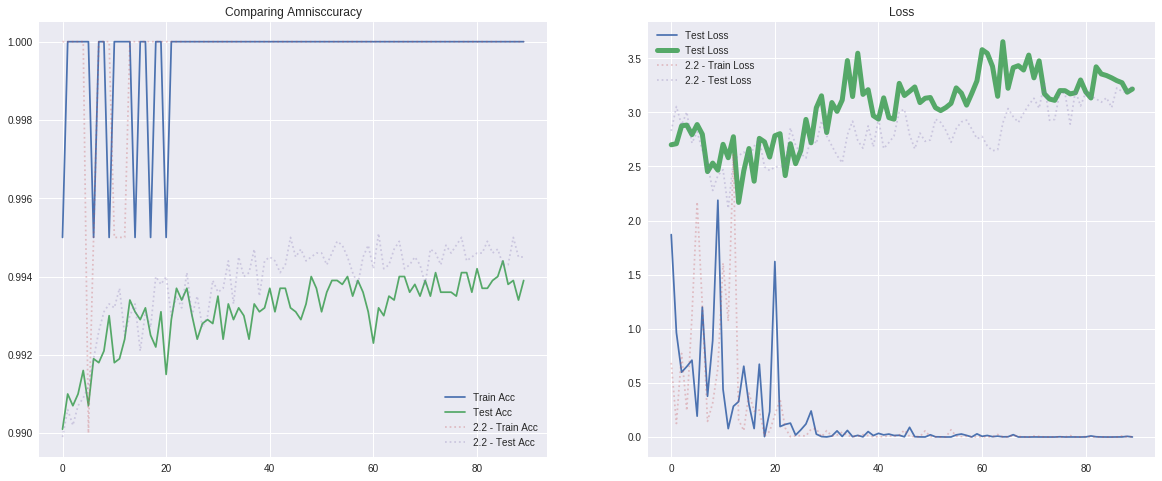

In [35]:
tailLength = -90

plt.figure(figsize=(20,8))

# Plot Accuracy
plt.subplot(1,2,1);
plt.plot(trainingAccuracyList[tailLength:], label="Train Acc");
plt.plot(testAccuracyList[tailLength:], label="Test Acc");

plt.plot(prev_resultsDic["trainAcc"][tailLength:], label="2.2 - Train Acc", alpha=0.3, linestyle=':');
plt.plot(prev_resultsDic["testAcc"][tailLength:], label="2.2 - Test Acc", alpha=0.3, linestyle=':');

plt.title("Comparing Amnisccuracy");
plt.legend();

# Plot Loss
plt.subplot(1,2,2);
plt.plot(trainingLossList[tailLength:], label="Test Loss");
plt.plot(testLossList[tailLength:], label="Test Loss", linewidth=5);

plt.plot(prev_resultsDic["trainLoss"][tailLength:], label="2.2 - Train Loss", alpha=0.3, linestyle=':');
plt.plot(prev_resultsDic["testLoss"][tailLength:], label="2.2 - Test Loss", alpha=0.3, linestyle=':');

plt.title("Loss");
plt.legend();

In [40]:
print(max(prev_resultsDic["testAcc"]));
print(max(testAccuracyList));

0.9951
0.9944
